<a href="https://colab.research.google.com/github/vanof/neural_networks/blob/master/Digits_Recognition_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [0]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [0]:
X_train = X_train.float()
X_test = X_test.float()

In [0]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [0]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

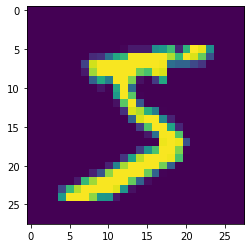

tensor(5)


In [0]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [0]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [0]:
torch.cuda.is_available()

True

In [0]:
!nvidia-smi

Wed May  6 19:32:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    36W / 250W |    765MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0065, -0.0294, -0.0136,  ..., -0.0043, -0.0036,  0.0120],
         [-0.0115, -0.0242, -0.0040,  ..., -0.0311,  0.0258, -0.0097],
         [ 0.0233,  0.0108,  0.0082,  ...,  0.0016, -0.0004, -0.0083],
         ...,
         [-0.0198,  0.0169, -0.0347,  ..., -0.0177,  0.0069,  0.0246],
         [-0.0343, -0.0231,  0.0266,  ...,  0.0295,  0.0031, -0.0128],
         [-0.0199,  0.0092,  0.0331,  ..., -0.0341,  0.0093, -0.0252]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([ 0.0142,  0.0077, -0.0145,  0.0145, -0.0227,  0.0202, -0.0319, -0.0027,
          0.0294, -0.0003,  0.0056, -0.0356,  0.0342, -0.0108,  0.0278, -0.0309,
         -0.0109, -0.0123,  0.0261, -0.0235,  0.0096, -0.0029,  0.0281, -0.0019,
          0.0309,  0.0011,  0.0354,  0.0303, -0.0269, -0.0215,  0.0059, -0.0184,
         -0.0230, -0.0327, -0.0059,  0.0227, -0.0189,  0.0081,  0.0077,  0.0023,
         -0.0189, -0.0203,  0.0115, -0.0057, -0.0104,  0.0065, 

In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [0]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.9379, device='cuda:0')
tensor(0.9411, device='cuda:0')
tensor(0.9423, device='cuda:0')
tensor(0.9422, device='cuda:0')
tensor(0.9417, device='cuda:0')
tensor(0.9442, device='cuda:0')
tensor(0.9411, device='cuda:0')
tensor(0.9458, device='cuda:0')
tensor(0.9484, device='cuda:0')
tensor(0.9485, device='cuda:0')
tensor(0.9485, device='cuda:0')
tensor(0.9460, device='cuda:0')
tensor(0.9437, device='cuda:0')
tensor(0.9448, device='cuda:0')
tensor(0.9471, device='cuda:0')
tensor(0.9496, device='cuda:0')
tensor(0.9486, device='cuda:0')
tensor(0.9455, device='cuda:0')
tensor(0.9484, device='cuda:0')
tensor(0.9454, device='cuda:0')
tensor(0.9528, device='cuda:0')
tensor(0.9471, device='cuda:0')
tensor(0.9462, device='cuda:0')
tensor(0.9482, device='cuda:0')
tensor(0.9518, device='cuda:0')
tensor(0.9512, device='cuda:0')
tensor(0.9487, device='cuda:0')
tensor(0.9494, device='cuda:0')
tensor(0.9522, device='cuda:0')
tensor(0.9509, device='cuda:0')
tensor(0.9514, device='cuda:0')
tensor(0

KeyboardInterrupt: ignored

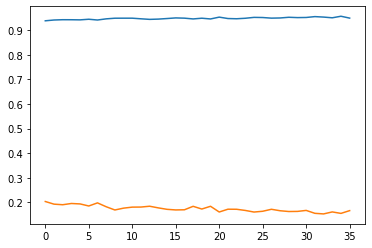

In [0]:
plt.plot(test_accuracy_history)
plt.plot(test_loss_history);

In [0]:
!nvidia-smi

Wed May  6 19:33:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    36W / 250W |    767MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  